# animating a single particle trial
Tim Tyree<br>
6.8.2021

In [1]:
from lib.my_initialization import *
from lib.utils.pbc import *
import shutil

/Users/timothytyree/opt/miniconda3/envs/pyenv/lib/python3.9/site-packages/statsmodels/compat/pandas.py:61: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


In [2]:
from numpy.random import MT19937
from numpy.random import RandomState, SeedSequence
# seed=123456789#for original movie suite
seed=1
#random number stream A
rs = RandomState(MT19937(SeedSequence(seed)))
#random number stream B
# rs = RandomState(MT19937(SeedSequence(987654321)))

#get distance metric
distance_L2_pbc=get_distance_L2_pbc(width=1,height=1)
np.random.seed(seed)

# define module

In [3]:
# @njit
def format_particles(frameno,t,x_values,y_values,pid_values,round_t_to_n_decimals=5):
    n_tips = x_values.shape[0]
    dict_out = {
        'frame':frameno,
        't': np.around(t,round_t_to_n_decimals),
        'n': n_tips,
        'x': x_values,
        'y': y_values,
        'particle':pid_values,
    }
    return dict_out

from numba import jit,njit
@njit
def normalRandom():
    return np.random.normal()

@njit
def uniformRandom():
    return np.random.uniform(0,1)
# normalRandom(),uniformRandom()

@njit
def levyRandom2D(alpha):
    th = 2*np.pi*np.random.uniform(0,1)
    ul = np.random.uniform(0,1)**(-1./alpha)
    dWx = ul*np.cos(th)
    dWy = ul*np.sin(th)
    return np.array([dWx,dWy])
# dWx,dWy = stepscale*levyRandom2D(alpha)
# dWx,dWy 

In [4]:
# np.random.uniform(0,1)

In [5]:
#DONE: dev function that returns a list of x coordinates and a list of y coordinates
#DONE: make a dict_out
# levyRandom2D(alpha)

In [6]:
#Scrum 6.8.2021
#DONE: plot all particle positions with this ic.  
#DONE: translate monte carlo into python
#DONE: make a movie for simplest case up to time tmax=1
#DONE: repeat with each attractive force between all particles 
#DONE: repeat with explicitely uniform ic.
#DONE: repeat with each attractive force between all particles

#Scrum 7.1.2021
#TODO(later): add force_code for small, constant repulsive force plus inverse powerlaw attractive force
#DONE: add option to generate tip log using particle model with 1/r force 
#TODO(later): copy estimates for force between particles from the full models (LR and FK)
#TODO(later): generate particle tip log for FK model. save as .csv
#TODO(later): generate particle tip log for LR model. save as .csv

# generate video

In [67]:
N=150
Nfinal=6 #~1m run time
Nfinal=0
L=5
# L=10
np.random.seed(42)
x_values=rs.uniform(size=N)*L
y_values=rs.uniform(size=N)*L
t=0

In [68]:
rs

RandomState(MT19937) at 0x7FB4870AE440

In [69]:
use_uniform_ic=True
use_uniform_ic=False
if use_uniform_ic:
    Nrow=4
#     Nrow=10
    #explicitely uniform ic.
    uvals=np.linspace(0,L*Nrow/(Nrow+1),Nrow)
    x_values,y_values=np.meshgrid(uvals,uvals)
    x_values=x_values.flatten()+L/(2*(Nrow+1))
    y_values=y_values.flatten()+L/(2*(Nrow+1))
    #explicitely enter ^these values in my c simulation and run it
    N = x_values.shape[0]

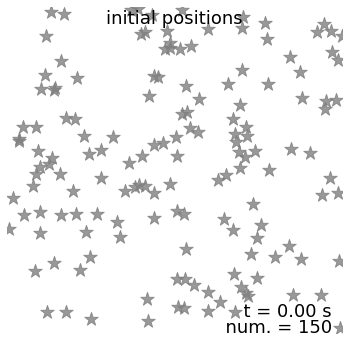

In [70]:
#return a scatter plot that may be saved as png
annotating=True
message='initial positions'
fig=ScatterPlotSnapshot(x_values,y_values,t,width=L,height=L,
                        annotating=annotating,message=message,inch=6)
plt.show()

In [71]:
#for snapshot output
save_folder=f"{nb_dir}/Figures/mov"
if os.path.exists(save_folder):
    #cleanse the old snapshot folder
    shutil.rmtree(save_folder)
os.mkdir(save_folder)
    
frameno=1
save_fn=None
inch=6
annotating=True

# message='without forces'
# force_code=0
# varkappa=0
# message='with anti-spring forces'
# force_code=1
# varkappa=-5
message='with inverse powerlaw forces'
force_code=2
# varkappa=1.552

In [72]:
#define model parameters
# #FK
# r=0.7 #cm 
# varkappa=1.552 #cm^2/s
# D=0.115 #cm^2/s
# # save_every=25
# save_every=5
# # save_every=1 #45 min

#LR
r=0.5 #cm 
varkappa=9.3 #cm^2/s
D=0.42 #cm^2/s
save_every=5 
# save_every=1
# save_every=1000000000
# varkappa=0 #no attraction

kappa=1e5 #Hz
Dt=1e-5;dt=1e-5
# tmax=500
tmax=1 #s

#for forces
x0=5
# no_repulsion=1
# no_attraction=1
no_repulsion=0
no_attraction=0
seed=123456789
#skipping reflect,set_second, and neighbor functionality

#define constants
alpha=1. #ballistic
alpha=2. #diffusive
# alpha=1.5 #levy-esque
# message=f'with {alpha=}'
message=' '
stepscale=np.sqrt(2*D*Dt) #diffusive
# stepscale=(2*D*Dt)**(1/alpha)
probreact=kappa*dt
T_net=0;count_net=0
np.random.seed(seed)
dist_cutoff=1e-2
iter_per_movestep = round(Dt/dt)
impulse_prefactor= varkappa * Dt
tiarray=np.zeros(N)
tfarray=np.zeros(N)
epsilon=5e-2  #reactions happen
# epsilon=5e-4  #reactions happen?
#heretim
#for csv output
# data_folder=f"{nb_dir}/data/local_results/collision_test"
data_folder=f"{nb_dir}/data/local_results/levy_test"
if not os.path.exists(data_folder):
    os.mkdir(data_folder)
data_folder=data_folder+"/Log"
if not os.path.exists(data_folder):
    os.mkdir(data_folder)
data_fn=f"pbc_seed_{seed}_fc_{force_code}_r_{r}_D_{D}_L_{L}_kappa_{kappa}_varkappa_{varkappa}_alpha_{alpha}_log.csv"

step=0
recording_locations=True
recording_snapshots=True
# recording_locations=False
# recording_snapshots=False
print("running simulation...");
t=-Dt
# still_running=True;
exit_code=-1;T=-9999.
#initialize positions
# #uniform random ic
# x_values=rs.uniform(size=N)*L
# y_values=rs.uniform(size=N)*L
# #explicitely uniform ic
# uvals=np.linspace(0,L,5)
# x_values,y_values=np.meshgrid(uvals,uvals)
# x_values=x_values.flatten()
# y_values=y_values.flatten()

#lower case: world coordinates
#upper case: material coordinates
x=x_values.copy()
y=y_values.copy()
x_old=x_values.copy()
y_old=y_values.copy()
x_new=x_values.copy()
y_new=y_values.copy()
X=x_values.copy()
Y=y_values.copy()
X_old=x_values.copy()
Y_old=y_values.copy()
X_new=x_values.copy()
Y_new=y_values.copy()
zeros=np.zeros_like(x_values)
zerosint=np.zeros_like(x_values).astype('int')
still_running=zerosint==zerosint
caught=zerosint.copy()-9999#!=zerosint
# //start set_second kernel
# //end set_second kernel
#make still_running into still_running_values
dict_out_lst=[]
# while(still_running.any()):
while(still_running.sum()>Nfinal):
    # //reinitialize_kernel, which copies X,Y_new to X,Y_old
    min_dist_old=zeros+9999999
    i_neighbor=zerosint-1
    x_old=x_new
    y_old=y_new
    t=t+Dt;
    # reset the net forces
    Fx_net=zeros.copy()
    Fy_net=zeros.copy()
    #sum_each_force_kernel
    for i in range(N):
        if(still_running[i]):
            for j in range(i+1,N):
                if(still_running[j]):
                    #compute displacement vector with pbc
                    dx = subtract_pbc_1d(x_old[j],x_old[i],L);
                    dy = subtract_pbc_1d(y_old[j],y_old[i],L);
                    dist2=dx*dx+dy*dy;
                    if (dist2<1e-8):
                        dist2=float(1e-8)
                    dist = np.sqrt(dist2)
                    #compute displacement due to drift
                    impulse_factor=0.
                    if (force_code==1):
                      #spring
                      impulse_factor=impulse_prefactor*(dist-x0)/dist;
                    if (force_code==2):
                      #QED2: force ~ inverse power law
                      impulse_factor=impulse_prefactor/dist2;
                    if (force_code==3):
                      #QED3: force ~ inverse square power law
                      impulse_factor=impulse_prefactor/dist2/dist;
                    #set impulse_factor to zero if it is explicitly forbidden by the user input
                    if ((no_attraction==1) & (impulse_factor>0)):
                        impulse_factor=0.
                    if ((no_repulsion==1) & (impulse_factor<0)):
                        impulse_factor=0.
                    #sum Fx_net, Fy_net according to a symplectic (momentum conserving) integrator
                    Fx_net[i]=Fx_net[i]+dx*impulse_factor;
                    Fy_net[i]=Fy_net[i]+dy*impulse_factor;
                    Fx_net[j]=Fx_net[j]-dx*impulse_factor;
                    Fy_net[j]=Fy_net[j]-dy*impulse_factor                    
                    #determine if they are closer than epsilon
                    if dist<epsilon:
                        #remove if they are
                        still_running[i]=False
                        still_running[j]=False
                        #heretim
                        uncatch_set=set()
                        if caught[i]>=0: 
                            uncatch_set.update([caught[i]])
                            if caught[caught[i]]>=0:
                                uncatch_set.update([caught[caught[i]]])
                        if caught[j]>=0: 
                            uncatch_set.update([caught[j]])
                            if caught[caught[j]]>=0:
                                uncatch_set.update([caught[caught[j]]])
                        if len(uncatch_set)>0:
                            for k in uncatch_set:
                                caught[k]=-9999
    #compute the one_step given the net force, F_net
    for i in range(N):
        if(still_running[i]):
            if caught[i]<0:
                dxt=Fx_net[i];
                dyt=Fy_net[i];
                # compute displacement due to levy flight
                dxW,dyW = stepscale*levyRandom2D(alpha)
                # next spatial position, time integrating by a duration, Dt. enforce PBC.
                x_new[i]=periodic(x_old[i]+dxW+dxt,L);
                y_new[i]=periodic(y_old[i]+dyW+dyt,L);
            else:
                j=caught[i]
                ti=tiarray[i]
                tf=tfarray[i]            
                #compute displacement vector with pbc
                dx = subtract_pbc_1d(x_old[j],x_old[i],L)
                dy = subtract_pbc_1d(y_old[j],y_old[i],L)      
                xl = dx - (x_old[j]-x_old[i])
                yl = dy - (y_old[j]-y_old[i])
                #compute average location
                xavg = x_old[i] + 0.5*dx 
                yavg = y_old[i] + 0.5*dy
                #compute frac to interpolate by
                frac = (t-ti)/(tf-ti)
                frac = np.min((1,frac))
                x_new[i] = periodic(x_old[i]*(1-frac) + (xavg+xl)*frac,L)
                y_new[i] = periodic(y_old[i]*(1-frac) + (yavg+yl)*frac,L)
    #reaction_kernel
    for i in range(N):
        if(still_running[i]&(caught[i]<0)):
            # // each i,j pair is reached once per call to kernel_measure
            for j in range(i+1,N):
                if(still_running[j]&(caught[j]<0)):
                    # // compute distance between particles that are still running
                    dist=dist_pbc(x_new[i],y_new[i],x_new[j],y_new[j],L);
                    in_range=dist<r;
                    # // in_range=true;//uncomment for smeared method
                    # // if two particles are in range
                    if(in_range):
                        # // determine whether those two particles react via the simple method
                        reacts=probreact>uniformRandom();
                        # // determine whether those two particles react via the smeared method
                        # // sig=sigmoid(dist, r, beta);
                        # // reacts=probreact*sig>uniformRandom();
                        if(reacts):
                            exit_code=1;
                            T=t;
#                             still_running[i]=False;
#                             still_running[j]=False;
                            #uncatch any previous catches
                            if caught[i]>=0: caught[caught[i]]=-9999
                            if caught[j]>=0: caught[caught[j]]=-9999
                            #catch these two
                            caught[i]=j;
                            caught[j]=i;
                            #determine deltat
                            deltat = dist**2/(4*(varkappa+2*D))
                            #determine ti,tf
                            tiarray[i]=t
                            tfarray[i]=t+deltat
                            tiarray[j]=t
                            tfarray[j]=t+deltat
    if step%save_every==0:
        x_plot=x_new[still_running]
        y_plot=y_new[still_running]
        c_plot = np.array(['gray']*y_plot.shape[0])
        caugh=caught[still_running]
        for i in range(y_plot.shape[0]):
            if caugh[i]>=0:
                c_plot[i]='r'
        if recording_snapshots:
            #save result as png
            SaveScatterPlotSnapshot(x_plot,y_plot,t,
                                    c=c_plot,
                                    width=L,height=L,
                            frameno=frameno,save_folder=save_folder,
                            annotating=annotating,message=message)
#             print(f"- saved pic at {frameno=}")
        if (recording_locations)&(x_plot.shape[0]>0):
            pid_values = np.arange(x_values.shape[0])[still_running]
            #append particle locations to log, dict_out_lst
            dict_out=format_particles(frameno,t,x_plot,y_plot,pid_values=pid_values)
            dict_out_lst.append(dict_out)
    
        frameno+=1

    #shut simulation down if it's taking too long...
    if (t>tmax):
        for i in range(N):
            still_running[i]=False;
            exit_code=-99;
    
    step+=1
    #end while running
    
#record this trial
if (exit_code>0):
    if (T>0.):
        T_net=T_net+T;
        count_net=count_net+1;
    
print(f"simulation complete!")

running simulation...
simulation complete!


In [73]:
N

150

In [74]:
# epsilon=0.05; #cm # distance removals happen at
# epsilon=5e-4  #reactions happen?


In [75]:
#TODO(later): njit the whole function

In [76]:
#save particle locations as csv
saving=recording_locations
# saving=False
printing=True
df = pd.concat([pd.DataFrame(dict_out) for dict_out in dict_out_lst])
df.reset_index(inplace=True, drop=True)
if saving:
    #save the recorded data
    os.chdir(data_folder)
    df.to_csv(data_fn, index=False)
    if printing:
        print('saved to:')
        print(os.path.abspath(data_fn))
    #     #if the end of AF was indeed reachded, append a row recording this
    #     if n_tips==0:
    #         next_id = df.index.values[-1]+1
    #         df = pd.concat([df,pd.DataFrame({'t': float(save_every_n_frames*h+t),'n': int(n_tips)}, index = [next_id])])
    #save the recorded data
#     #     df.round(round_output_decimals).to_csv(data_dir_log, index=False)
#     if printing:
#         print('saved to:')
#         print(data_dir_log)

saved to:
/Users/timothytyree/Documents/GitHub/bgmc/python/data/local_results/levy_test/Log/pbc_seed_123456789_fc_2_r_0.5_D_0.42_L_5_kappa_100000.0_varkappa_9.3_alpha_2.0_log.csv


In [77]:
beep(2)

-n 
-n 


0

In [78]:
#TODO: wrap all this into a functional routine
#TODO: generate a folder of tip logs with fixed parameters and variable seed
#TODO(option 1): copy ^these logs to care.  compute trajectories.
#TODO(option 2): copy method to compute trajectories from care
#TODO: compute mean dRdt versus R in the last few milliseconds before annihilation. plot.
#TODO: p
#TODO(option 2): 
print(os.path.abspath(data_fn))

/Users/timothytyree/Documents/GitHub/bgmc/python/data/local_results/levy_test/Log/pbc_seed_123456789_fc_2_r_0.5_D_0.42_L_5_kappa_100000.0_varkappa_9.3_alpha_2.0_log.csv


In [ ]:
#concatenate the folder of .png files
os.chdir(f'{nb_dir}/../vid/src')
os.system(f'./concat_folder_png.sh');

ffmpeg version 5.1.2 Copyright (c) 2000-2022 the FFmpeg developers
  built with Apple clang version 14.0.0 (clang-1400.0.29.202)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/5.1.2_6 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags= --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libaribb24 --enable-libbluray --enable-libdav1d --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librist --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libsvtav1 --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libspeex --enable-libsoxr --enable-libzmq --enable-libzimg --disable-libjack --

In [ ]:
#return a scatter plot that may be saved as png
annotating=True
message='final positions'
fig=ScatterPlotSnapshot(x_new,y_new,t,width=L,height=L,
                        annotating=annotating,message=message,inch=6)
plt.show()

In [ ]:
os.system(f'open {nb_dir}/../vid/mov/out.mov')

In [ ]:
#Q: why aren't I seeing them pull together slowly?
print(f'annihilation duration: {deltat/dt=:.0f} steps')
print(f'annihilation duration: {deltat/dt/save_every=:.0f} frames')

In [ ]:
t

In [ ]:
#TODO: compute single-particle MSD for various alpha and plot
#TODO: dev measurement function of rates
#FK
'/Users/timothytyree/Documents/GitHub/bgmc/python/data/local_results/levy_test/Log/pbc_seed_123456789_fc_2_r_0.7_D_0.115_L_5_kappa_100000.0_varkappa_1.552_alpha_1.5_log.csv'
#LR
'/Users/timothytyree/Documents/GitHub/bgmc/python/data/local_results/levy_test/Log/pbc_seed_123456789_fc_2_r_0.5_D_0.42_L_5_kappa_100000.0_varkappa_9.3_alpha_1.5_log.csv'

32